## Импорты

In [ ]:
%pylab inline
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product
import pylab

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/dist-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['pylab', 'product']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## Загрузка

In [ ]:
# Данные о пассажирах авиакомпаний США с 1949 по 1960 год.
data = pd.read_csv('AirPassengers.csv', index_col=['Month'], parse_dates=['Month'], dayfirst=True)

In [ ]:
data

Passengers
Month                 
1949-01-01         112
1949-02-01         118
1949-03-01         132
1949-04-01         129
1949-05-01         121
...                ...
1960-08-01         606
1960-09-01         508
1960-10-01         461
1960-11-01         390
1960-12-01         432

[144 rows x 1 columns]

Text(0, 0.5, 'Passengers')

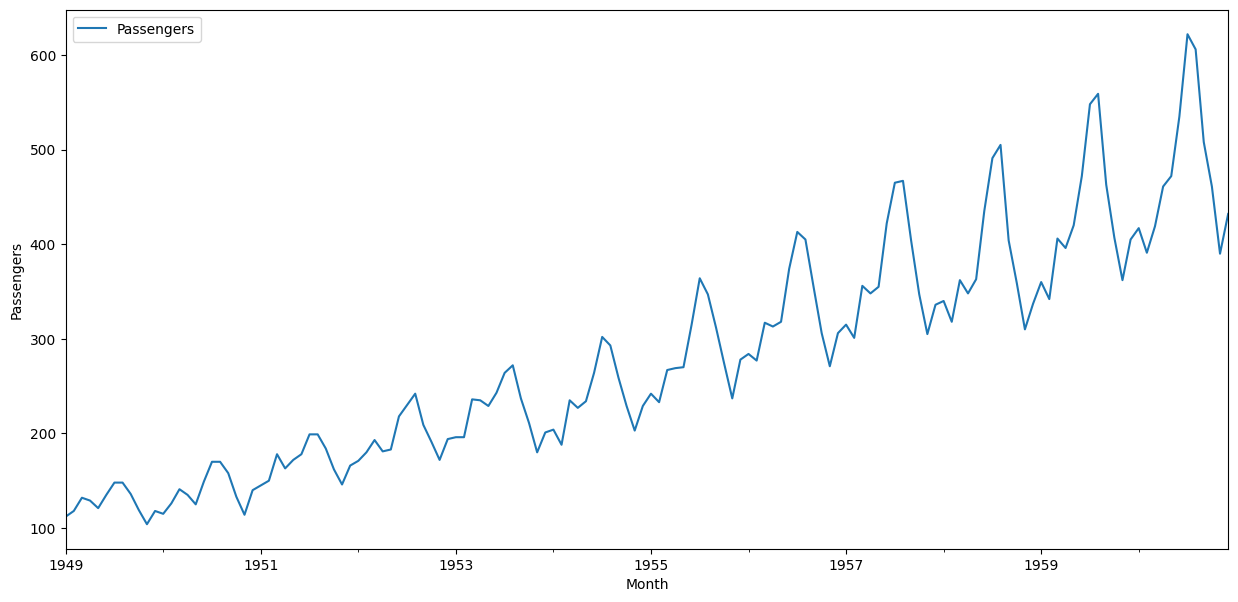

In [ ]:
data.plot(figsize = (15,7))
plt.ylabel('Passengers')

In [ ]:
sm.tsa.stattools.adfuller(data.Passengers)

(0.8153688792060498,
 0.991880243437641,
 13,
 130,
 {'1%': -3.4816817173418295,
  '5%': -2.8840418343195267,
  '10%': -2.578770059171598},
 996.692930839019)

Поскольку p-значение не меньше 0,05, мы не можем отвергнуть нулевую гипотезу, значит ряд не стационарен

Проверка стационарности и STL-декомпозиция ряда:




Критерий Дики-Фуллера: p=0.991880


<Figure size 1500x1000 with 0 Axes>

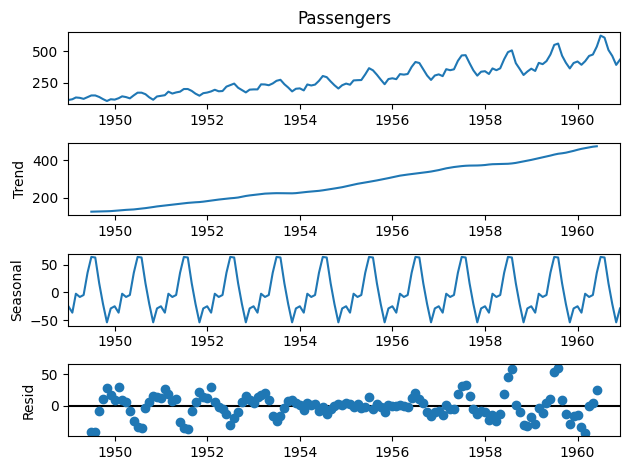

In [ ]:
plt.figure(figsize = (15,10))
sm.tsa.seasonal_decompose(data.Passengers).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Passengers)[1])

## Стабилизация дисперсии




Оптимальный параметр преобразования Бокса-Кокса: 0.148023
Критерий Дики-Фуллера: p=0.617162


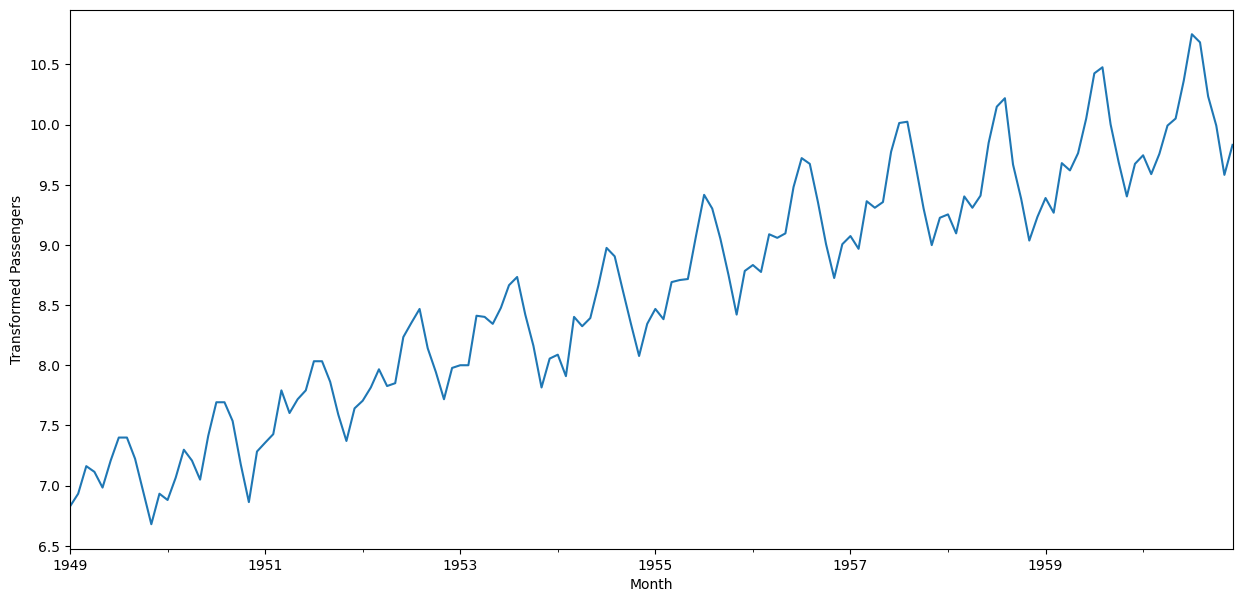

In [ ]:
data['Passengers_box'], lmbda = stats.boxcox(data.Passengers)
data.Passengers_box.plot(figsize=(15,7))
plt.ylabel(u'Transformed Passengers')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Passengers_box)[1])

## Стационарность

Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.052505


<Figure size 1500x1000 with 0 Axes>

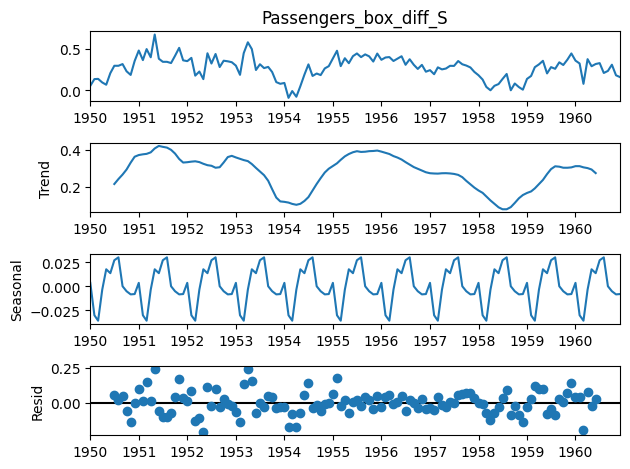

In [ ]:
plt.figure(figsize = (15,10))
data['Passengers_box_diff_S'] = data.Passengers_box - data.Passengers_box.shift(12)
sm.tsa.seasonal_decompose(data.Passengers_box_diff_S[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Passengers_box_diff_S[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000304


<Figure size 1500x1000 with 0 Axes>

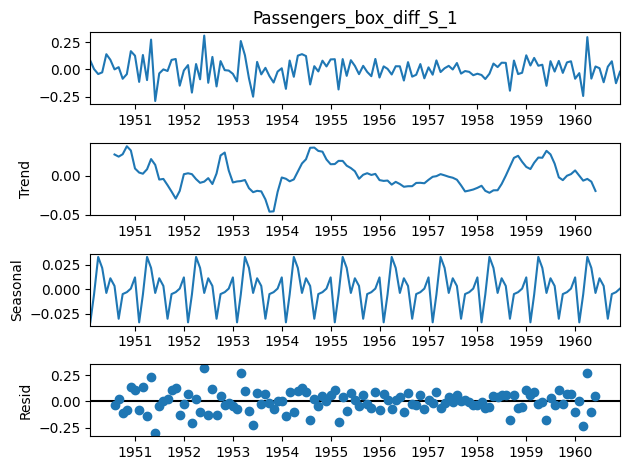

In [ ]:
plt.figure(figsize = (15,10))
data['Passengers_box_diff_S_1'] = data.Passengers_box_diff_S - data.Passengers_box_diff_S.shift(1)
sm.tsa.seasonal_decompose(data.Passengers_box_diff_S_1[13:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data.Passengers_box_diff_S_1[13:])[1])

## Подбор модели

*Посмотрим* на ACF и PACF полученного ряда:

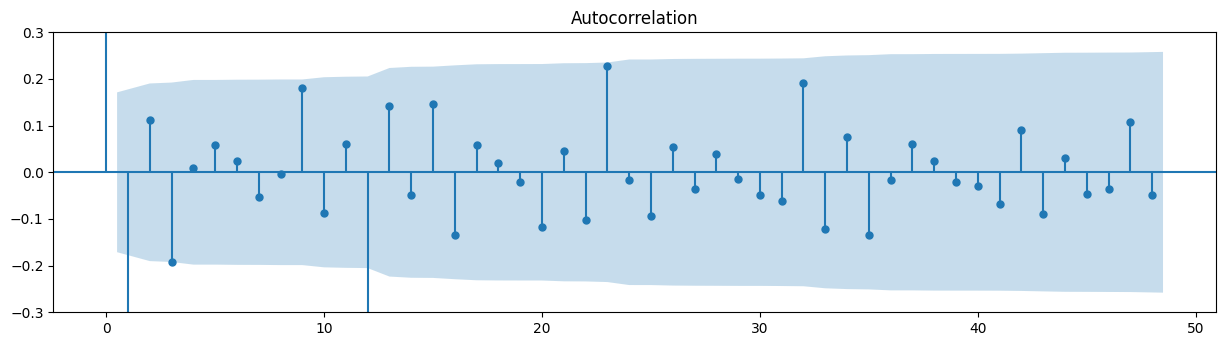

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


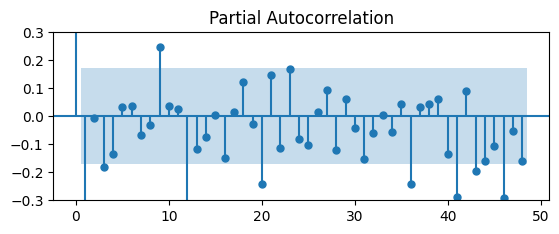

In [ ]:
plt.figure(figsize = (15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.Passengers_box_diff_S_1[13:].values.squeeze(), lags=48, ax=ax)
plt.ylim([-0.3, 0.3])
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(data.Passengers_box_diff_S_1[13:].values.squeeze(), lags=48, ax=ax)
plt.ylim([-0.3, 0.3])
pylab.show()

Начальное значение для параметра Q даёт номер последнего сезонного лага, при котором автокорреляция значима. Параметр q задаётся номером последнего несезонного лага, при котором автокорреляция значима. 

Начальное приближение P = 1, поскольку длина сезонного периода S = 12. Аналогично, p задаётся как номер последнего несезонного лага, при котором частичная автокорреляция значима. В данном случае можно взять начальное приближение
p = 1.

Начальные приближения:  Q=1,q=1,P=1,p=1

In [ ]:
ps = range(0, 1)
d=1
qs = range(0, 2)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [ ]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

8

In [ ]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data.Passengers_box[:135], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

CPU times: user 3.49 s, sys: 3.16 s, total: 6.65 s
Wall time: 8.47 s


In [ ]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True)[:5])

     parameters         aic
5  (0, 1, 0, 1) -250.180991
7  (0, 1, 1, 1) -248.956951
6  (0, 1, 1, 0) -247.534109
1  (0, 0, 0, 1) -241.833190
3  (0, 0, 1, 1) -239.842934


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                     Passengers_box   No. Observations:                  135
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 128.090
Date:                            Thu, 06 Apr 2023   AIC                           -250.181
Time:                                    03:22:59   BIC                           -241.769
Sample:                                01-01-1949   HQIC                          -246.764
                                     - 03-01-1960                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3110      0.083     -3.766      0.000      -0.473      -0.149
ma.S.L12      -0.5091      0.096   

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Критерий Стьюдента: p=0.816810
Критерий Дики-Фуллера: p=0.000000


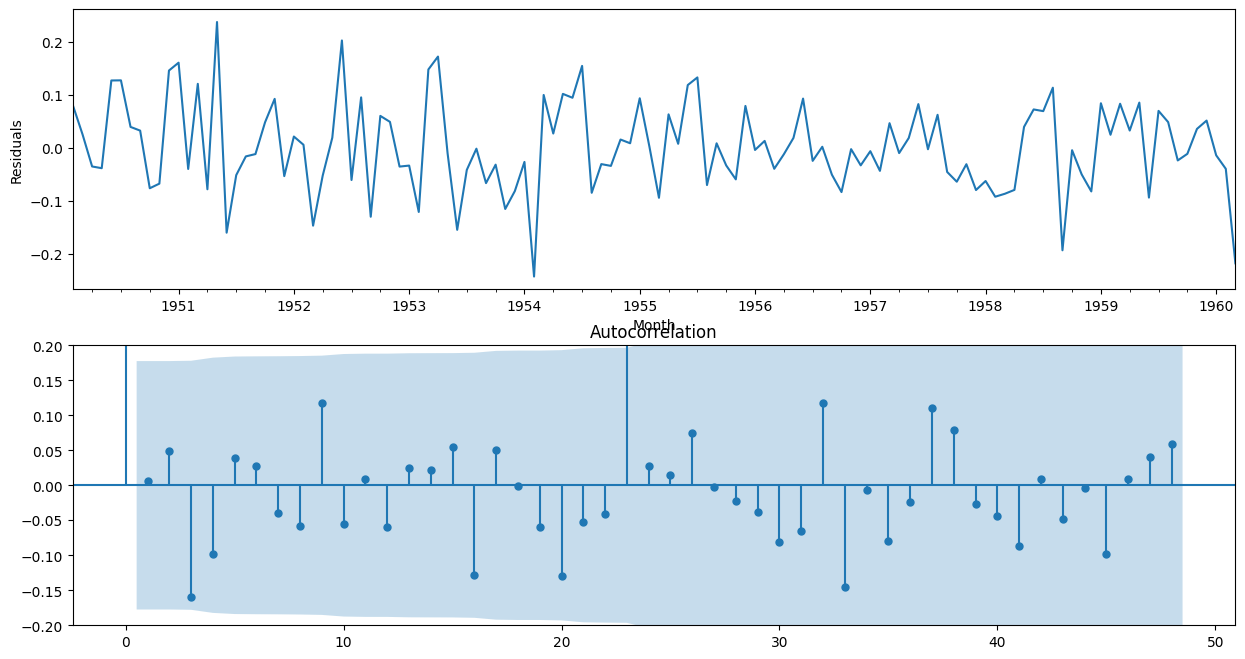

In [ ]:
plt.figure(figsize=(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)
plt.ylim([-0.2, 0.2])

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


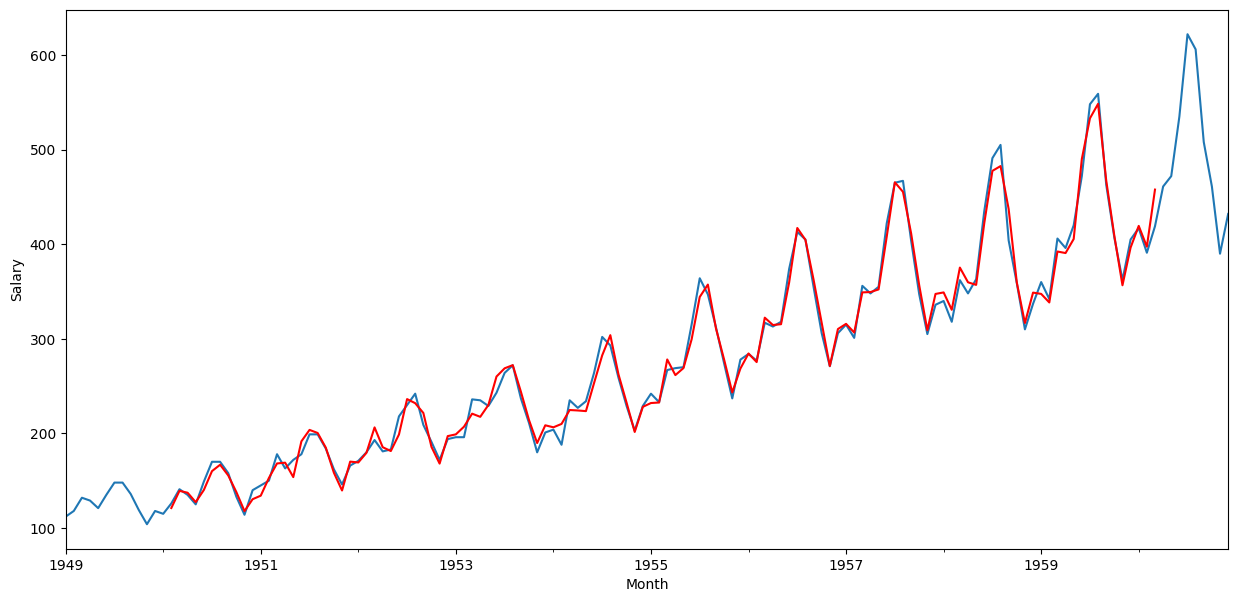

In [ ]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize=(15,7))
data.Passengers.plot()
data.model[13:].plot(color='r')
plt.ylabel('Salary')
plt.show()

In [ ]:
df2 = data[['Passengers']]
months = pd.date_range('1961-01-01', '1963-01-01', freq='MS')
future = pd.DataFrame(index=months, columns=df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=135, end=170), lmbda)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data[['Passengers']].shape

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(144, 1)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


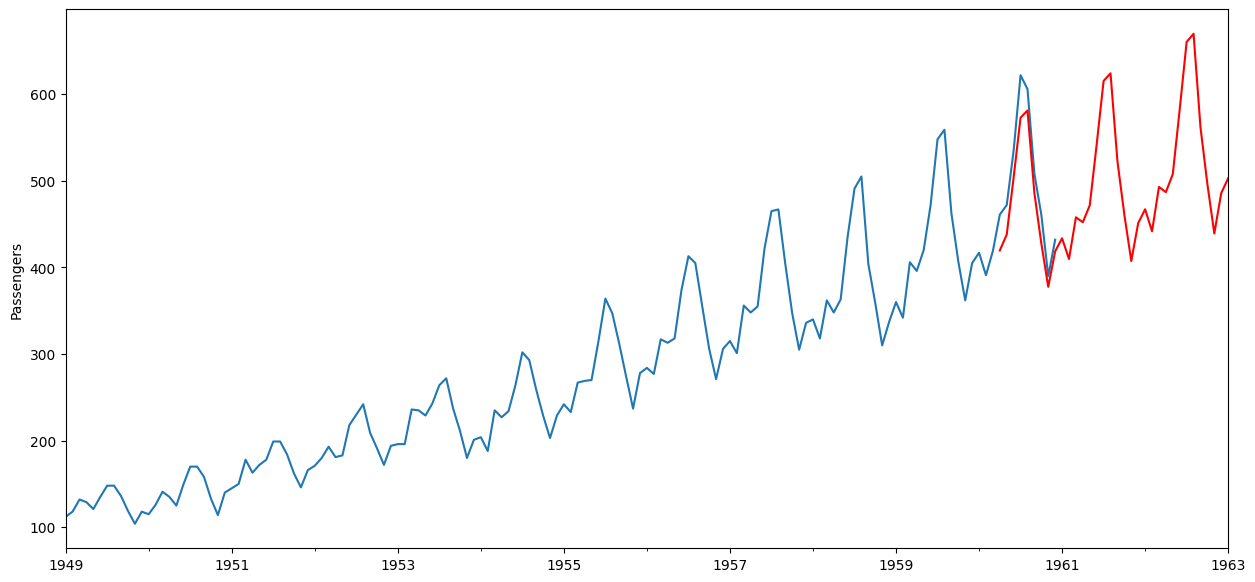

In [ ]:
plt.figure(figsize=(15,7))
df2.Passengers.plot()
df2.forecast.plot(color='r')
plt.ylabel('Passengers')
plt.show()

In [ ]:
df2 = data[['Passengers']]
months = pd.date_range('1961-01-01', '1963-01-01', freq='MS')
future = pd.DataFrame(index=months, columns=df2.columns)
df2 = pd.concat([df2, future])
df2['forecast'] = invboxcox(best_model.predict(start=144, end=170), lmbda)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


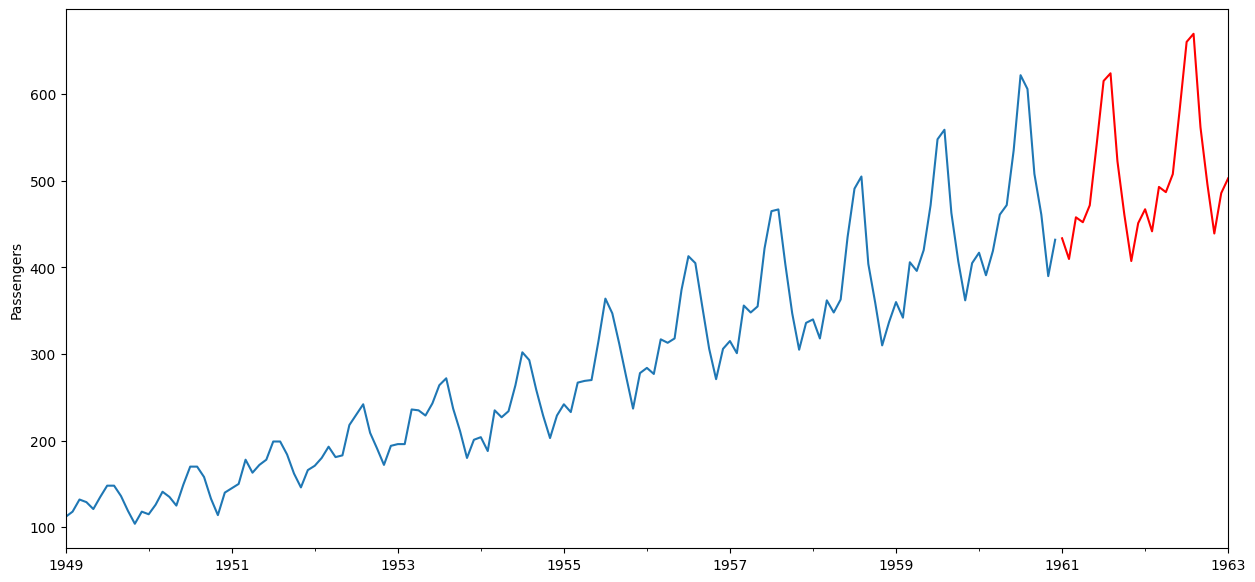

In [ ]:
plt.figure(figsize=(15,7))
df2.Passengers.plot()
df2.forecast.plot(color='r')
plt.ylabel('Passengers')
plt.show()